In [87]:
import numpy as np
import pandas as pd
import pylab as plt
from datetime import datetime
from dateutil.parser import parse
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'axes', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Machine Learning with Decision Trees
June 18, 2019

This notebook gives the source code for the decision tree exercise at Tech & AI To Improve Human Capital. Participants filled out a survey (72 responses) based on this fictional scenario:

**A new cohort of 100 staff have just been hired, and will start this summer. We need to decide how many bike racks or parking spaces to build for them. To do so, we'll use data on current staff to build a machine learning model. For fun, we'll also predict whether staff prefer classical music or heavy metal.**

The notebook is in Python and makes use of SciKitLearn, a widely used library for machine learning.

### 1. Load and prepare the data

In [88]:
# The data was collected on Google Forms and downloaded as a CSV file.
# We'll load it as a dataframe ('df'), clean up the column names, and take a look.

df = pd.read_csv('HD_ML_survey.csv')
df.columns = ['state','age','gender','exercise_regime','purchase_history','mode_of_travel','music_choice']

df.head()

,state,age,gender,exercise_regime,purchase_history,mode_of_travel,music_choice
0,DC,25-31,Female,Keep fit through jogging or gym.,"Gardening supplies, Theater tickets",Walk or bike,Classical music
1,Virginia,56-61,Male,Keep fit through jogging or gym.,"Gardening supplies, Dog food / cat food",Train,Classical music
2,Maryland,32-38,Female,Keep fit through jogging or gym.,"Gardening supplies, Bluetooth speaker, Dog foo...",Train,Classical music
3,Virginia,39-45,Female,Keep fit through jogging or gym.,"Gardening supplies, Bluetooth speaker, Dog foo...",Car,Heavy metal / rock
4,Maryland,32-38,Female,Netflix is my most strenuous exercise.,"Gardening supplies, Bluetooth speaker, Theater...",Train,Heavy metal / rock


In [89]:
#df = df[df.apply(lambda row: not row.astype(str).str.contains('Prefer').any(), axis=1)]

### 2. Inspect the data
* Before building a model, visualize the data to understand what's in it.

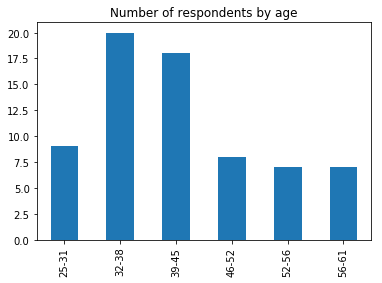

In [90]:
# Our respondents are from a broad set of ages

pd.Series(df.age.value_counts(sort=False),index=['25-31','32-38','39-45','46-52','52-56','56-61']).plot(kind='bar',title='Number of respondents by age')

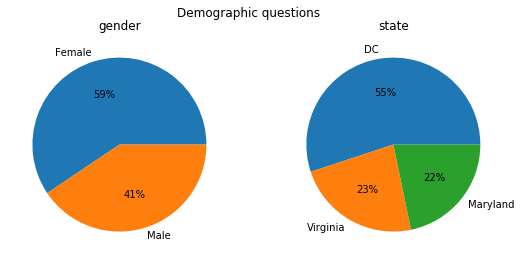

In [91]:
# There are slightly more women than men, and the majority live in DC.

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[9,4])
pies = ['gender','state']

for n,i in enumerate(pies):
    ax = axes.flatten()[n]
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax)
    ax.set(ylabel='',title=i)

fig.suptitle("Demographic questions");

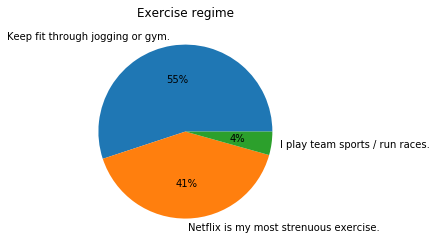

In [92]:
df.exercise_regime.value_counts().plot(kind = 'pie', autopct='%1.0f%%',title='Exercise regime')
plt.ylabel('');

#### --> We'll use supervised learning methods, so having a target variable is crucial. We have two target variables. We'll build one model to predict mode of transport, and a second model to predict music choice. The classes are fairly evenly balanced.

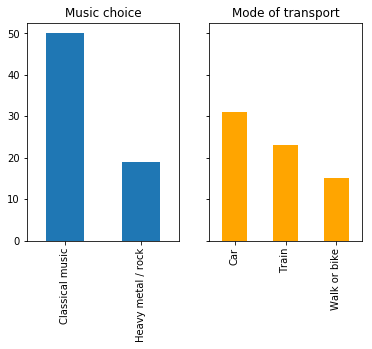

In [93]:
fig,axes = plt.subplots(1,2,sharey=True)
df.mode_of_travel.value_counts().plot(kind='bar',ax=axes[1],title='Mode of transport',color='orange')
df.music_choice.value_counts().plot(kind='bar',ax=axes[0],title='Music choice');

### 3. Create a machine-readable set of features
We need to transform the data a bit before our algorithm can work with it:
* For categorical features (eg. State = DC, Maryland or Virginia), transform them into dummy variables.
* This will give us a new column for each possible value, encoded as 0 or 1. (So if you live in DC, you'll be marked '1' in the DC column and '0' in the Virginia and Maryland columns.

In [94]:
# Transform the purchases data from string (eg. 'yoga mat, theater tickets') to a list.  

df.purchase_history = df.purchase_history.astype(str)
df.purchase_history = [cell.split(',') for cell in df.purchase_history]  

In [95]:
# Create dummies for purchase history

items = ['Theater tickets','Yoga mat','Bluetooth speaker / headphones',
             'Gardening or home improvement gear',' Presents for my kids']

for item in items:
    df[item] = [item in cell for cell in df.purchase_history]
    df[item] = df[item].map({False:0,True:1})

In [96]:
# Transform gender, household_type, state, food and exercise to dummies

for feature in ['gender','state','exercise_regime']:
    dummy_feature = pd.get_dummies(df[feature])
    df = pd.concat([df,dummy_feature], axis=1)

In [97]:
# Take the mid-point of the age range
df['age_continuous'] = df.age.map({'25-31':28,'32-38':35,'39-45':42,'46-52':49,'52-56':54,'56-61':58,'Prefer not to say':45})

In [98]:
# Map the TRANSPORT and MUSIC_CHOICE columns (our target variables) to 0s/1s

y_transport = df.mode_of_travel.map({'Train':0,'Car':0,'Walk or bike':1})
y_music = df.music_choice.map({'Classical music':0,'Heavy metal / rock':1})

# Note, we're using the following binary values:

# TRANSPORT -- Train or car: 0, Walk or bike, 1
# MUSIC -- Classical: 0, Heavy metal / rock: 1

In [99]:
features = ['state', 'age_continuous', 'gender', 'Theater tickets', 'Yoga mat',
       'Bluetooth speaker / headphones', 'Gardening or home improvement gear',
       ' Presents for my kids', 'Female', 'Male',
       'Female', 'Male', 'DC', 'Maryland', 'Virginia',
       'I play team sports / run races.', 'Keep fit through jogging or gym.',
       'Netflix is my most strenuous exercise.']

### 4. Build decision tree models

##### 4.1 TRANSPORT

In [100]:
# In machine learning, the set of predictive features is typically denoted X. The target variable is denoted y.
# This reflects mathematical notation where y = f(X)   [outcome y is a function of input features x1 ... xN]

# Here are the feature we'll use:

X = ['age_continuous', 'Female', 'Male', 'DC', 'Maryland', 'Virginia', 'Theater tickets', 'Yoga mat',
       'Bluetooth speaker / headphones', 'Gardening or home improvement gear',
       ' Presents for my kids','I play team sports / run races.', 'Keep fit through jogging or gym.',
       'Netflix is my most strenuous exercise.']

In [101]:
df[X].head(2)

,age_continuous,Female,Male,DC,Maryland,Virginia,Theater tickets,Yoga mat,Bluetooth speaker / headphones,Gardening or home improvement gear,Presents for my kids,I play team sports / run races.,Keep fit through jogging or gym.,Netflix is my most strenuous exercise.
0,28,1,0,1,0,0,0,0,0,0,0,0,1,0
1,58,0,1,0,0,1,0,0,0,0,0,0,1,0


In [124]:
# Split the data into training and test sets. We take 70% of data to train the model, 30% to evaluate it.

from sklearn.model_selection import train_test_split

X_train_transport, X_test_transport, y_train_transport, y_test_transport = train_test_split(df[X],y_transport,test_size=0.31)

In [125]:
# X_train is the features for our training set, y_train is the corresponding labels (eg. 'classical fan','heavy metal lover')

print("rows and columns in X_train: {}".format(X_train_transport.shape))
print("rows and columns in y_train: {}".format(y_train_transport.shape))
print("rows and columns in X_test: {}".format(X_test_transport.shape))
print("rows and columns in y_test: {}".format(y_test_transport.shape))

rows and columns in X_train: (47, 14)
rows and columns in y_train: (47,)
rows and columns in X_test: (22, 14)
rows and columns in y_test: (22,)


In [126]:
# First set up the model that we'll use:

tree_transport = DecisionTreeClassifier(max_depth=3)

# Then pass it the training data:

tree_transport.fit(X_train_transport,y_train_transport)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [127]:
# Visualize the model

export_graphviz(tree_transport, out_file='tree.dot', 
                feature_names = X,
                class_names = ['Train/car','walk/bike'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

#from IPython.display import Image
#Image('tree1.png')

##### 4.2 MUSIC CHOICE

In [173]:
X_train_music, X_test_music, y_train_music, y_test_music = train_test_split(df[X],y_music,test_size=0.3)

In [174]:
tree_music = DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)
tree_music.fit(X_train_music,y_train_music)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [175]:
export_graphviz(tree_music, out_file='tree2.dot', 
                feature_names = X,
                class_names = ['Classical','Metal'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [177]:
#Image('tree2.png')

### 4. Predict against test set, evaluate performance

In [178]:
# We built a decision tree classifier with the training data. Now let's run the test data through it.
# We'll output the predictions it made and look at them:

predictions_transport = tree_transport.predict(X_test_transport)

print("TRANSPORT: First 10 predictions: {}".format(predictions_transport[:10].tolist()))

TRANSPORT: First 10 predictions: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


In [179]:
n_samples = len(predictions_transport)

In [180]:
# Is the model any good? Let's check how many of the predicted value equal the actual values.

n_correct = sum(predictions_transport == y_test_transport)
accuracy = n_correct / n_samples * 100

print("TRANSPORT - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    n_correct,n_samples,accuracy))

TRANSPORT - We predicted 17 right out of 22 examples. That's a 77.3 % accuracy rate.


In [181]:
# Check accuracy for music

predictions_music = tree_music.predict(X_test_music)

print("MUSIC - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    sum(predictions_music == y_test_music),n_samples,sum(predictions_music == y_test_music)/n_samples*100))

MUSIC - We predicted 13 right out of 22 examples. That's a 59.1 % accuracy rate.


--> Note that the transport model addresses an easy task, whereas predicting musical taste seems difficult. What could boost the prediction accuracy? Two approaches: get more data to train your models on, or improve the model.

### 5. Will a more complex model give us better accuracy?
* Random Forest is an algorithm that builds a decisions of decision trees, each with a slightly different subset of the training data, then makes predictions by averaging the results of each tree. 
* Building a large 'forest' can boost prediction accuracy. But a complex model risks overfitting the data, and benefits of adding more trees peaks after a while.

In [244]:
from sklearn.model_selection import cross_val_score       # This is a variant on train-test split.

In [263]:
n_estimators = np.arange(1,40,1)           # We'll build a Random Forest with 1 tree, 2 trees, 3 trees, etc, up to 50 trees.
results = []                             # We'll test the prediction accuracy of each model, and store the results.

In [264]:
for i in n_estimators:
    transport_rf = RandomForestClassifier(n_estimators=i,random_state=10)
    scores = cross_val_score(transport_rf,df[X],y_transport,cv=5)
    results.append(scores.mean())

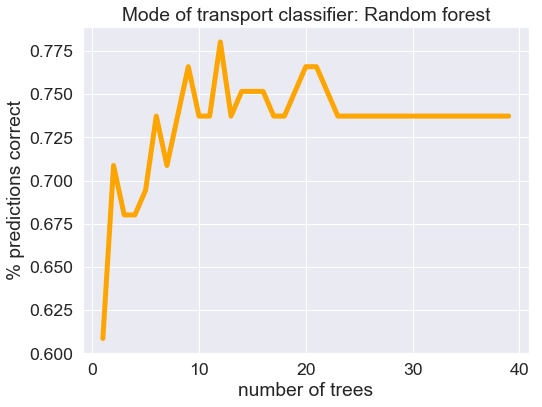

In [315]:
sns.set(font_scale=1.6)
f, ax = plt.subplots(figsize=[8,6])
sns.lineplot(n_estimators,results,color='orange',ax=ax,linewidth=5)
fig = plt.gca()
fig.set(title="Mode of transport classifier: Random forest",ylabel='% predictions correct', xlabel='number of trees');

--> performance rises with number of trees, then levels off. It may be worth using a RF with say 10-15 trees. Note that on large and complex datasets, it can be worth using a large number of trees (100s or even 1000s).

### 6. Demo of parameter tuning
ML models have parameters, eg. for a decision-tree you can specify the maximum depth and the minimum number of samples to include in any split. We'll tune the model by trying different parameters to find the combination that works best.

In [192]:
from sklearn.model_selection import GridSearchCV

In [193]:
# First let's specify the set of parameters to look at, and the values to search among.
# ---> we'll try any number of trees between 2 and 40, and several options for max depth and minimum samples per leaf.

param_grid = {'n_estimators':np.arange(2,40),'max_depth':[3,4,5,6],'min_samples_leaf':[2,3,4,5]}

In [194]:
# We'll build a new model for each combination of the parameters (this is a Grid Search), and store the results.

grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
grid_search.fit(X_train_transport,y_train_transport)

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [195]:
print("The best parameters were: {}".format(grid_search.best_params_))
print("The best model classified {} percent of examples correctly.".format((grid_search.best_score_*100).round(1)))


The best parameters were: {'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 14}
The best model classified 85.1 percent of examples correctly.


### 7. Demo of feature importance
* Sometimes we want to know which features the model made use of. This helps inform us about what set of rules just got constructed. It's also informative in its own right: eg. in education policy, you might not need to predict student performance, but finding out which factors influence most strongly is of interest.

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


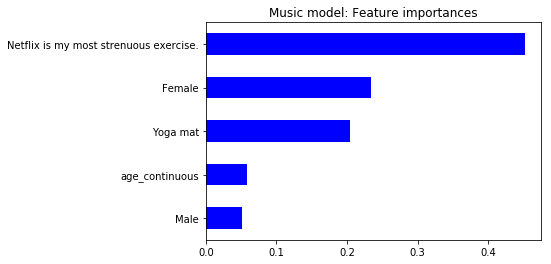

In [196]:
feat_importance = pd.Series(tree_music.feature_importances_,index=df[X].columns)
feat_importance.nlargest(5).plot(kind='barh',title='Music model: Feature importances',colors='b')
plt.gca().invert_yaxis();

In [197]:
rf_transport = RandomForestClassifier()
rf_transport.fit(X_train_transport,y_train_transport,);

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


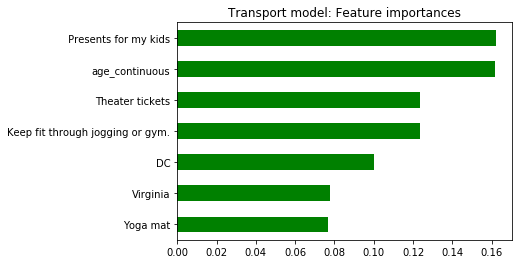

In [198]:
feat_importance = pd.Series(rf_transport.feature_importances_,index=df[X].columns)
feat_importance.nlargest(7).plot(kind='barh',title='Transport model: Feature importances',colors='g')
plt.gca().invert_yaxis();

#### Thanks for participating! Contacts: Nick Jones (njones@worldbank.org), Mersedeh Tariverdi (mtariverdi@worldbank.org)